In [3]:
# 3D Model Structural Analysis & IFC Export

This notebook demonstrates a three-stage process:
1. **Stage 1 – 3D Model Geometry Analysis:**  
   Loads a 3D model file (e.g., a Rhino `.3dm` file), analyzes its geometry, and classifies key architectural elements (walls, floors, ceilings, columns, beams) based on geometric criteria.
   
2. **Stage 2 – Structural Grid & Line Placement:**  
   Identifies vertex positions from the model and suggests a structural grid (e.g., columns placed every 6 meters) to align elements between floors.
   
3. **Stage 3 – Placement & IFC Export:**  
   Places generic columns and beams based on the grid and exports the elements into an IFC file for BIM compatibility.

*Note: The geometry classification and IFC export portions are simplified and serve as a starting point for further development.*


SyntaxError: invalid character '–' (U+2013) (3194556658.py, line 4)

In [65]:
# Import necessary libraries
%pip install rhino3dm ifcopenshell trimesh matplotlib numpy

import numpy as np
import matplotlib.pyplot as plt
import trimesh
import rhino3dm  # For reading Rhino .3dm files
import ifcopenshell  # For IFC export
import ifcopenshell.api


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
# Non Layers Version

import numpy as np
import rhino3dm

# Function to extract geometry objects from a Rhino3dm model.
def extract_geometry(model):
    """
    Extracts geometry objects from a Rhino3dm model.
    Returns a list of geometry objects (e.g., surfaces, Breps, Extrusions).
    """
    geometry = []
    for obj in model.Objects:
        geom = obj.Geometry
        if geom:
            geometry.append(geom)
    return geometry

# Function to compute the normal vector for a given surface.
def get_normal_vector(surface):
    """
    Computes the normal vector for a given surface.
    For Extrusion objects, converts them to a Brep (calling ToBrep with a boolean argument)
    and uses the normal of the first face.
    For Brep objects, uses the normal of the first face.
    If the object has a NormalAt method, it will be used as a fallback.
    """
    try:
        type_name = type(surface).__name__
        if type_name == "Extrusion":
            # Convert the Extrusion to a Brep (providing False for splitKinkyFaces)
            brep = surface.ToBrep(False)
            if brep and len(brep.Faces) > 0:
                face = brep.Faces[0]
                normal = face.NormalAt(0.5, 0.5)
                norm_val = np.linalg.norm([normal.X, normal.Y, normal.Z])
                if norm_val != 0:
                    return np.array([normal.X, normal.Y, normal.Z]) / norm_val
        elif type_name == "Brep":
            if len(surface.Faces) > 0:
                face = surface.Faces[0]
                normal = face.NormalAt(0.5, 0.5)
                norm_val = np.linalg.norm([normal.X, normal.Y, normal.Z])
                if norm_val != 0:
                    return np.array([normal.X, normal.Y, normal.Z]) / norm_val
        # Fallback: if the surface has a NormalAt method directly.
        if hasattr(surface, "NormalAt"):
            normal = surface.NormalAt(0.5, 0.5)
            norm_val = np.linalg.norm([normal.X, normal.Y, normal.Z])
            if norm_val != 0:
                return np.array([normal.X, normal.Y, normal.Z]) / norm_val
    except Exception as e:
        print("Error computing normal for surface:", e)
    # Fallback normal (horizontal)
    return np.array([0, 0, 1])

# Function to classify geometry solely based on the computed normals.
def classify_geometry(geometry):
    classified = {"walls": [], "floors": [], "ceilings": [], "columns": [], "beams": []}
    
    for geom in geometry:
        normal = get_normal_vector(geom)
        # If the normal is nearly vertical (i.e., [0, 0, ±1]), classify as a floor.
        if np.allclose(np.abs(normal), [0, 0, 1], atol=0.2):
            classified["floors"].append(geom)
        # If the normal is nearly horizontal (i.e., [±1, 0, 0] or [0, ±1, 0]), classify as a wall.
        elif (np.allclose(np.abs(normal), [1, 0, 0], atol=0.2) or 
              np.allclose(np.abs(normal), [0, 1, 0], atol=0.2)):
            classified["walls"].append(geom)
        else:
            # Fallback: if the normal doesn't clearly indicate either, treat as floor.
            classified["floors"].append(geom)
        
        # Placeholders for additional classification for columns and beams.
        if hasattr(geom, 'IsCylinder') and geom.IsCylinder:
            classified["columns"].append(geom)
        if hasattr(geom, 'IsBeam') and geom.IsBeam:
            classified["beams"].append(geom)
            
    return classified

# Example usage for Stage 1:
file_path = "basicformMETERS.3dm"  # Replace with the actual path to your Rhino file.
try:
    model = rhino3dm.File3dm.Read(file_path)
    geometry = extract_geometry(model)
    classified_elements = classify_geometry(geometry)
    print("Geometry Classification Results:")
    for key, items in classified_elements.items():
        print(f"  {key.capitalize()}: {len(items)} element(s)")
except Exception as e:
    print("Error loading or processing the file:", e)


Geometry Classification Results:
  Walls: 20 element(s)
  Floors: 14 element(s)
  Ceilings: 0 element(s)
  Columns: 0 element(s)
  Beams: 0 element(s)


In [ ]:
#with layers
import rhino3dm

def get_bounding_box(geom):
    """Returns the bounding box corners of a geometry"""
    bbox = geom.GetBoundingBox()  # Removed the True argument
    return bbox.Min, bbox.Max  # Returns the min and max points

def are_touching(bbox1, bbox2, tolerance=0.01):
    """Checks if two bounding boxes are touching (within tolerance)"""
    min1, max1 = bbox1
    min2, max2 = bbox2
    
    # Check if they are at the same height (Z level)
    same_z = abs(min1.Z - min2.Z) < tolerance and abs(max1.Z - max2.Z) < tolerance
    
    # Check if their X and Y ranges overlap
    overlap_x = (min1.X <= max2.X and max1.X >= min2.X)
    overlap_y = (min1.Y <= max2.Y and max1.Y >= min2.Y)
    
    return same_z and (overlap_x or overlap_y)

def merge_floors(floor_geometries):
    """Merges separate floor pieces that are touching into unified floors"""
    merged_floors = []
    used = set()  # Track which geometries have been merged

    for i, geom1 in enumerate(floor_geometries):
        if i in used:
            continue
        
        merged_group = [geom1]
        bbox1 = get_bounding_box(geom1)

        for j, geom2 in enumerate(floor_geometries):
            if i != j and j not in used:
                bbox2 = get_bounding_box(geom2)
                if are_touching(bbox1, bbox2):
                    merged_group.append(geom2)
                    used.add(j)

        merged_floors.append(merged_group)
        used.add(i)
    
    return merged_floors  # Returns grouped floors as lists of touching geometries

def classify_by_layer_and_merge(model):
    """Classifies geometry by layer and merges touching floors"""
    classified = {"walls": [], "floors": [], "ceilings": [], "columns": [], "beams": []}
    
    for obj in model.Objects:
        layer_index = obj.Attributes.LayerIndex
        layer_name = model.Layers[layer_index].Name.lower()  # Convert to lowercase
        geom = obj.Geometry
        
        if isinstance(geom, rhino3dm.Brep):  # Ensure it's a valid solid
            if "wall" in layer_name:
                classified["walls"].append(geom)
            elif "floor" in layer_name:
                classified["floors"].append(geom)
            elif "ceiling" in layer_name:
                classified["ceilings"].append(geom)
            elif "column" in layer_name:
                classified["columns"].append(geom)
            elif "beam" in layer_name:
                classified["beams"].append(geom)
    
    # Merge touching floors into unified groups
    classified["floors"] = merge_floors(classified["floors"])
    
    return classified

# Load model and classify
file_path = "basicformMETERS.3dm"
try:
    model = rhino3dm.File3dm.Read(file_path)
    classified_elements = classify_by_layer_and_merge(model)
    
    print("Geometry Classification after Merging Floors:")
    for key, items in classified_elements.items():
        print(f"  {key.capitalize()}: {len(items)} grouped element(s)")

except Exception as e:
    print("Error processing the file:", e)


Geometry Classification after Merging Floors:
  Walls: 17 grouped element(s)
  Floors: 1 grouped element(s)
  Ceilings: 2 grouped element(s)
  Columns: 1 grouped element(s)
  Beams: 0 grouped element(s)


In [56]:
import numpy as np
import rhino3dm

def get_all_vertices(geometry):
    """
    Extracts vertices from a list of geometry objects.
    For Breps, it iterates over the Vertices property (each vertex usually has a Location attribute).
    For other types, if a 'Points' attribute exists, it uses that.
    """
    vertices = []
    for geom in geometry:
        # Check if the geometry has a "Vertices" property (typical for Breps)
        if hasattr(geom, "Vertices"):
            for v in geom.Vertices:
                try:
                    # Some vertex objects have a Location property
                    if hasattr(v, "Location"):
                        vertices.append([v.Location.X, v.Location.Y, v.Location.Z])
                    else:
                        # Fallback: assume v itself is a point
                        vertices.append([v.X, v.Y, v.Z])
                except Exception as e:
                    print("Error processing a vertex:", e)
        # Fallback: if the geometry has a "Points" attribute
        elif hasattr(geom, "Points"):
            for pt in geom.Points:
                try:
                    vertices.append([pt.X, pt.Y, pt.Z])
                except Exception as e:
                    print("Error processing a point:", e)
    return np.array(vertices)

def main():
    # Replace with the actual path to your Rhino file.
    file_path = "basicformMETERS.3dm"
    try:
        model = rhino3dm.File3dm.Read(file_path)
        # Extract geometry from all objects that have geometry.
        geometry = [obj.Geometry for obj in model.Objects if obj.Geometry is not None]
        
        # Get all vertices from the extracted geometry.
        vertices = get_all_vertices(geometry)
        
        # Print the vertices.
        if vertices.size > 0:
            print("Extracted vertices:")
            print(vertices)
        else:
            print("No vertices were found in the geometry.")
    except Exception as e:
        print("Error loading or processing the file:", e)

if __name__ == '__main__':
    main()


Extracted vertices:
[[-3.00000000e+00  3.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.00000000e+00  3.00000000e+00]
 [-3.00000000e+00  3.00000000e+00  3.00000000e+00]
 [ 0.00000000e+00  3.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.00000000e+00  3.00000000e+00]
 [ 0.00000000e+00  6.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.00000000e+00  3.00000000e+00]
 [ 0.00000000e+00  6.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.00000000e+00  3.00000000e+00]
 [-3.00000000e+00  6.00000000e+00  0.00000000e+00]
 [-3.00000000e+00  6.00000000e+00  3.00000000e+00]
 [-3.00000000e+00  3.00000000e+00  0.00000000e+00]
 [-3.00000000e+00  3.00000000e+00  3.00000000e+00]
 [-3.00000000e+00  6.00000000e+00  0.00000000e+00]
 [-3.00000000e+00  6.00000000e+00  3.00000000e+00]
 [-3.00000000e+00  3.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  6.00000000e+00  0.00000000e+00]
 [-3.000000

In [76]:
pip install rhino3dm matplotlib numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


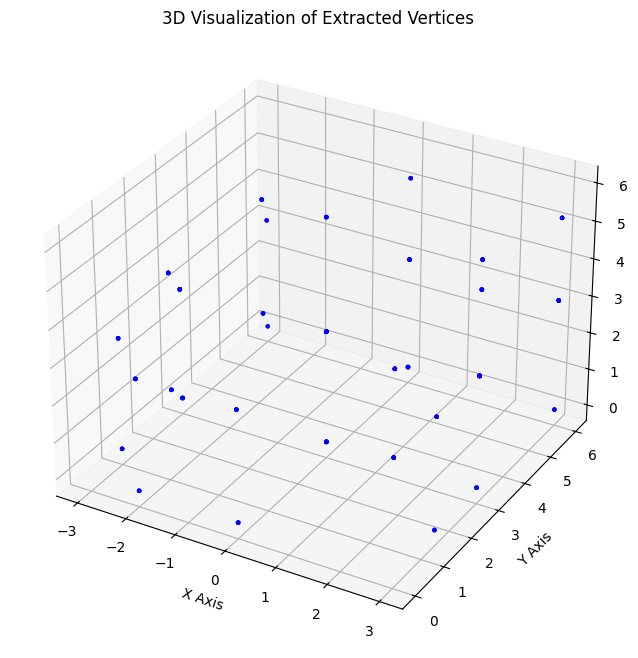

In [80]:
import numpy as np
import rhino3dm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def get_all_vertices(geometry):
    """
    Extracts vertices from Breps and Meshes.
    """
    vertices = []
    
    for geom in geometry:
        # Extract vertices from Brep
        if isinstance(geom, rhino3dm.Brep):
            for edge in geom.Edges:
                vertices.append([edge.PointAtStart.X, edge.PointAtStart.Y, edge.PointAtStart.Z])
                vertices.append([edge.PointAtEnd.X, edge.PointAtEnd.Y, edge.PointAtEnd.Z])
        
        # If it's already a Mesh, extract vertices directly
        elif isinstance(geom, rhino3dm.Mesh):
            for i in range(geom.Vertices.Count):
                v = geom.Vertices[i]
                vertices.append([v.X, v.Y, v.Z])

    return np.array(vertices)

# Load your Rhino 3DM file
file_path = "basicformMETERS.3dm"  # Update with the correct file path

try:
    model = rhino3dm.File3dm.Read(file_path)
    geometry = [obj.Geometry for obj in model.Objects if obj.Geometry is not None]

    # Extract vertices
    vertices = get_all_vertices(geometry)

    # Plot vertices in 3D
    if vertices.size > 0:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='b', marker='o', s=5)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        ax.set_title('3D Visualization of Extracted Vertices')
        
        plt.show()
    else:
        print("No vertices found in the geometry.")

except Exception as e:
    print("Error loading or processing the file:", e)


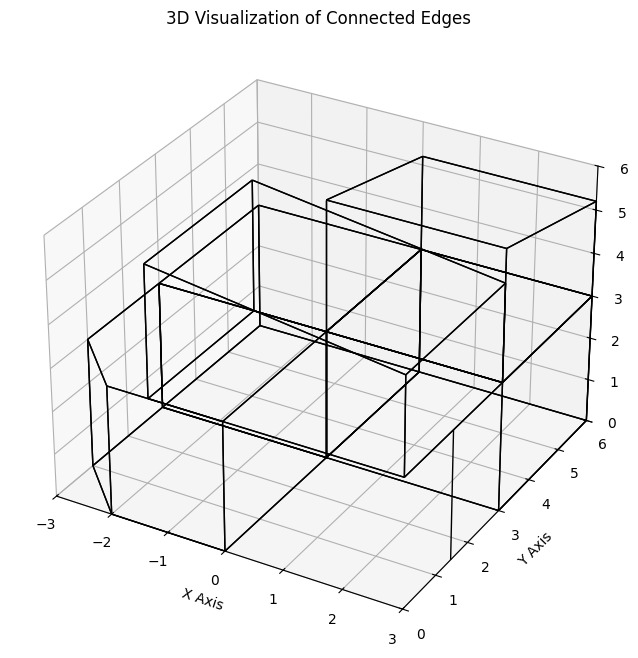

In [81]:
import rhino3dm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def get_all_edges(geometry):
    """
    Extracts edges from Breps and Meshes, returning pairs of connected vertices.
    """
    edges = []
    
    for geom in geometry:
        # Extract edges from Brep
        if isinstance(geom, rhino3dm.Brep):
            for edge in geom.Edges:
                start = [edge.PointAtStart.X, edge.PointAtStart.Y, edge.PointAtStart.Z]
                end = [edge.PointAtEnd.X, edge.PointAtEnd.Y, edge.PointAtEnd.Z]
                edges.append([start, end])
        
        # If it's a Mesh, extract edges by connecting vertices
        elif isinstance(geom, rhino3dm.Mesh):
            for i in range(geom.TopologyEdges.Count):
                line = geom.TopologyEdges.EdgeLine(i)
                start = [line.From.X, line.From.Y, line.From.Z]
                end = [line.To.X, line.To.Y, line.To.Z]
                edges.append([start, end])

    return np.array(edges)

# Load the Rhino 3DM file
file_path = "basicformMETERS.3dm"  # Update with your file path

try:
    model = rhino3dm.File3dm.Read(file_path)
    geometry = [obj.Geometry for obj in model.Objects if obj.Geometry is not None]

    # Extract edges
    edges = get_all_edges(geometry)

    # Plot edges in 3D
    if edges.size > 0:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Convert edges to a format suitable for Line3DCollection
        edge_lines = [np.array(edge) for edge in edges]
        line_collection = Line3DCollection(edge_lines, colors='black', linewidths=1)

        ax.add_collection3d(line_collection)

        # Set axis labels
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        ax.set_title('3D Visualization of Connected Edges')

        # Auto scale axes
        all_points = edges.reshape(-1, 3)
        ax.set_xlim([np.min(all_points[:, 0]), np.max(all_points[:, 0])])
        ax.set_ylim([np.min(all_points[:, 1]), np.max(all_points[:, 1])])
        ax.set_zlim([np.min(all_points[:, 2]), np.max(all_points[:, 2])])

        plt.show()
    else:
        print("No edges found in the geometry.")

except Exception as e:
    print("Error loading or processing the file:", e)



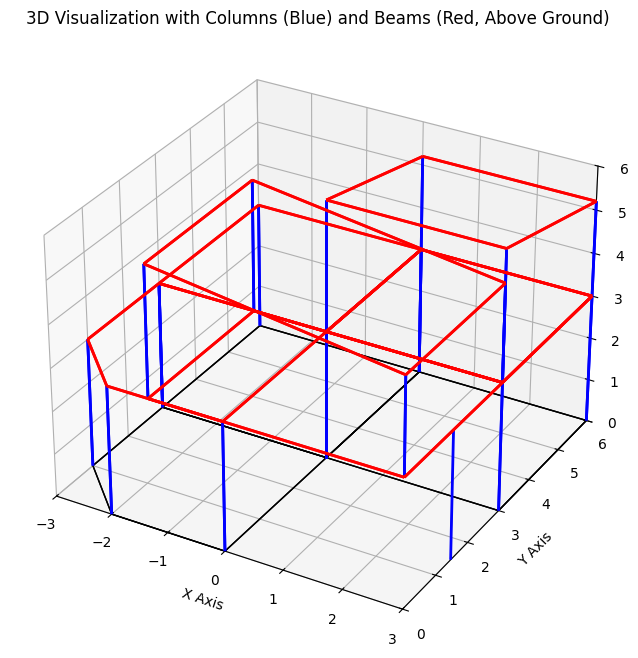

In [85]:
import rhino3dm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

def get_all_edges(geometry):
    """
    Extracts edges from Breps and Meshes, returning pairs of connected vertices.
    """
    edges = []
    
    for geom in geometry:
        # Extract edges from Brep
        if isinstance(geom, rhino3dm.Brep):
            for edge in geom.Edges:
                start = [edge.PointAtStart.X, edge.PointAtStart.Y, edge.PointAtStart.Z]
                end = [edge.PointAtEnd.X, edge.PointAtEnd.Y, edge.PointAtEnd.Z]
                edges.append([start, end])
        
        # If it's a Mesh, extract edges by connecting vertices
        elif isinstance(geom, rhino3dm.Mesh):
            for i in range(geom.TopologyEdges.Count):
                line = geom.TopologyEdges.EdgeLine(i)
                start = [line.From.X, line.From.Y, line.From.Z]
                end = [line.To.X, line.To.Y, line.To.Z]
                edges.append([start, end])

    return np.array(edges)

def add_structural_elements(edges):
    """
    Adds columns at vertical edges and beams along all non-ground horizontal & tilted edges.
    """
    columns = []
    beams = []

    # Find the lowest Z value (ground level)
    z_values = [point[2] for edge in edges for point in edge]
    ground_level = min(z_values) + 0.2  # Small buffer to avoid near-ground beams

    for edge in edges:
        start, end = edge
        vector = np.array(end) - np.array(start)

        # Identify columns (strictly vertical edges)
        if abs(vector[0]) < 0.1 and abs(vector[1]) < 0.1:  # Vertical alignment check
            columns.append(edge)

        # Identify beams (non-vertical edges, excluding those near ground level)
        elif abs(vector[2]) < 1.5 and start[2] > ground_level and end[2] > ground_level:
            beams.append(edge)

    return np.array(columns), np.array(beams)

# Load the Rhino 3DM file
file_path = "basicformMETERS.3dm"  # Update with your file path

try:
    model = rhino3dm.File3dm.Read(file_path)
    geometry = [obj.Geometry for obj in model.Objects if obj.Geometry is not None]

    # Extract edges
    edges = get_all_edges(geometry)
    
    # Identify columns and beams
    columns, beams = add_structural_elements(edges)

    # Plot edges, columns, and beams in 3D
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Convert edges to a format suitable for Line3DCollection
    edge_lines = [np.array(edge) for edge in edges]
    column_lines = [np.array(col) for col in columns]
    beam_lines = [np.array(beam) for beam in beams]

    # Add the original edges in black
    ax.add_collection3d(Line3DCollection(edge_lines, colors='black', linewidths=1))

    # Add columns in blue
    ax.add_collection3d(Line3DCollection(column_lines, colors='blue', linewidths=2))

    # Add beams in red (Now avoids beams near ground level)
    ax.add_collection3d(Line3DCollection(beam_lines, colors='red', linewidths=2))

    # Set axis labels
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('3D Visualization with Columns (Blue) and Beams (Red, Above Ground)')

    # Auto scale axes
    all_points = edges.reshape(-1, 3)
    ax.set_xlim([np.min(all_points[:, 0]), np.max(all_points[:, 0])])
    ax.set_ylim([np.min(all_points[:, 1]), np.max(all_points[:, 1])])
    ax.set_zlim([np.min(all_points[:, 2]), np.max(all_points[:, 2])])

    plt.show()

except Exception as e:
    print("Error loading or processing the file:", e)
